In [1]:
%load_ext supriya.ext.ipython
import supriya

## Realtime Server Node Tree Model

In [2]:
synth_a = supriya.Synth(frequency=333)
synth_b = supriya.Synth(frequency=444)
synth_c = supriya.Synth(frequency=555)
outer_group = supriya.Group()
inner_group = supriya.Group()
outer_group.extend([synth_a, inner_group, synth_c])
inner_group.append(synth_b)

In [3]:
# groups know about their children
for index, node in enumerate(outer_group.children):
    print(index, repr(node)) 

0 <- Synth: ???>
1 <- Group: ???>
2 <- Synth: ???>


In [4]:
# and nodes know about their parents
for distance, node in enumerate(synth_b.parentage):
    print(distance, repr(node))

0 <- Synth: ???>
1 <- Group: ???>
2 <- Group: ???>


In [5]:
# nodes can be iterated depthfirst and know their position in the tree
for child in outer_group.depth_first():
    print(repr(child), child.graph_order)

<- Synth: ???> (0,)
<- Group: ???> (1,)
<- Synth: ???> (1, 0)
<- Synth: ???> (2,)


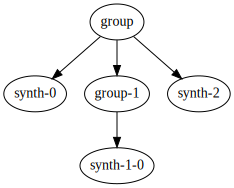

In [6]:
# we can visualize the unallocated node structure
_ = supriya.graph(outer_group)

In [7]:
# booting is just like in sclang
server = supriya.Server()
server.boot()

<Server: udp://127.0.0.1:57751, 8i8o>

In [8]:
# printing asks for the string representation of an object
# string representation are/can be different from interpreter representations
# we can query the node tree via /g_queryTree requests
print(server)

NODE TREE 0 group
    1 group


In [9]:
# allocating a group also recursively allocates its children
outer_group.allocate()
print(server)

NODE TREE 0 group
    1 group
        1000 group
            1001 default
                out: 0.0, amplitude: 0.1, frequency: 333.0, gate: 1.0, pan: 0.5
            1002 group
                1003 default
                    out: 0.0, amplitude: 0.1, frequency: 444.0, gate: 1.0, pan: 0.5
            1004 default
                out: 0.0, amplitude: 0.1, frequency: 555.0, gate: 1.0, pan: 0.5


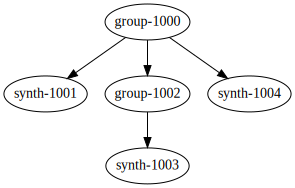

In [10]:
# we can visualize the allocated node structure
_ = supriya.graph(outer_group)

In [40]:
# TODO: synth and group control interfaces, and their mutability
synth_a["frequency"]

333.0

In [ ]:
# we can set synth controls, treating the synth like a dictionay
synth_a["frequency"] = 666
# and query them
print(synth_a["frequency"])

In [12]:
# the synth controls are also explicitly modeled, hidden inside the "controls" interface
for control_name in synth_a.controls:
    print(repr(synth_a.controls[control_name]))

<SynthControl: <+ Synth: 1001> "amplitude": 0.1 [kr]>
<SynthControl: <+ Synth: 1001> "frequency": 666.0 [kr]>
<SynthControl: <+ Synth: 1001> "gate": 1.0 [kr]>
<SynthControl: <+ Synth: 1001> "out": 0.0 [ir]>
<SynthControl: <+ Synth: 1001> "pan": 0.5 [kr]>


In [13]:
# groups also have a control interface, aggregating controls from synths in their subtree
for control_name in outer_group.controls:
    print(repr(outer_group.controls[control_name]))

<GroupControl: <+ Group: 1000> "amplitude" [kr]>
<GroupControl: <+ Group: 1000> "frequency" [kr]>
<GroupControl: <+ Group: 1000> "gate" [kr]>
<GroupControl: <+ Group: 1000> "out" [ir]>
<GroupControl: <+ Group: 1000> "pan" [kr]>


In [14]:
# we can allocate new nodes and move existing nodes in the same command
# synthdefs are also automatically allocated
# we use the completion message of the /s_new to perform the node allocation / movement
# this synth uses a non-default synthdef, which hasn't previously been allocated on the server
synth_d = supriya.Synth(synthdef=supriya.assets.synthdefs.pad)
inner_group.extend([synth_d, synth_a])

In [15]:
# iteration continues to work
for node in outer_group.children:
    print(repr(node))

<+ Group: 1002>
<+ Synth: 1004>


In [16]:
for control_name in outer_group.controls:
    print(control_name)

amplitude
filter_frequency
frequency
gate
out
pan


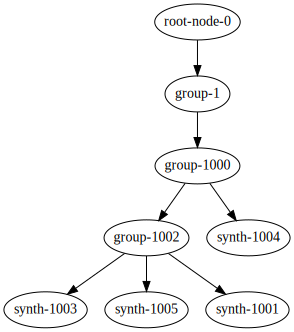

In [17]:
# we can also visualize the entire server node structure, including the root node and default group
_ = supriya.graph(server)

In [18]:
outer_group.free()

<- Group: ???>

In [19]:
print(server)

NODE TREE 0 group
    1 group


In [20]:
# explicitly freeing a group does not destructure its children
print(outer_group)

??? group
    ??? group
        ??? default
            amplitude: 0.1, frequency: 444.0, gate: 1.0, out: 0.0, pan: 0.5
        ??? pad
            amplitude: 0.1, filter_frequency: 1500.0, frequency: 440.0, gate: 1.0, out: 0.0, pan: 0.0
        ??? default
            amplitude: 0.1, frequency: 666.0, gate: 1.0, out: 0.0, pan: 0.5
    ??? default
        amplitude: 0.1, frequency: 555.0, gate: 1.0, out: 0.0, pan: 0.5


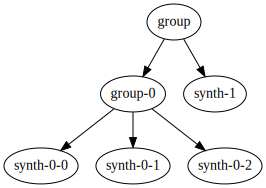

In [21]:
_ = supriya.graph(outer_group)

In [22]:
server.quit()

<Server: offline>

## OSC Command Aggregation

In [23]:
server = supriya.Server().boot()
server.debug_request_names = True

In [24]:
synth_a = supriya.Synth(frequency=333)
synth_b = supriya.Synth(frequency=444)
synth_c = supriya.Synth(frequency=555)
outer_group = supriya.Group()
inner_group = supriya.Group()
outer_group.extend([synth_a, inner_group, synth_c])
inner_group.append(synth_b)
print(outer_group)

??? group
    ??? default
        amplitude: 0.1, frequency: 333.0, gate: 1.0, out: 0.0, pan: 0.5
    ??? group
        ??? default
            amplitude: 0.1, frequency: 444.0, gate: 1.0, out: 0.0, pan: 0.5
    ??? default
        amplitude: 0.1, frequency: 555.0, gate: 1.0, out: 0.0, pan: 0.5


In [25]:
# let's allocate the default synthdef manually (you'll see why soon)
supriya.assets.synthdefs.default.allocate()

<SynthDef: default>

In [26]:
# we can spy on osc messages going to and coming from scsynth
with server.osc_io.capture() as transcript:
    outer_group.allocate()

In [27]:
# what was sent when we allocated that group? an osc bundle
# supriya models osc bundles and osc messages explicitly as classes
# the osc messages are a linearized version of depth-first allocation of the nodes in the subtree
for timestamp, osc_message in transcript.sent_messages:
    print(repr(osc_message))

OscBundle(
    contents=(
        OscMessage('/g_new', 1000, 0, 1),
        OscMessage('/s_new', 'default', 1001, 0, 1000, 'frequency', 333.0),
        OscMessage('/g_new', 1002, 3, 1001),
        OscMessage('/s_new', 'default', 1003, 0, 1002, 'frequency', 444.0),
        OscMessage('/s_new', 'default', 1004, 3, 1002, 'frequency', 555.0),
        OscMessage('/sync', 0),
        ),
    )


In [28]:
# we also have the responses from the server to each of those /s_new and /g_new commands
# and the /synced response as well
for timestamp, osc_message in transcript.received_messages:
    print(repr(osc_message))

OscMessage('/n_go', 1000, 1, -1, -1, 1, -1, -1)
OscMessage('/n_go', 1001, 1000, -1, -1, 0)
OscMessage('/n_go', 1002, 1000, 1001, -1, 1, -1, -1)
OscMessage('/n_go', 1003, 1002, -1, -1, 0)
OscMessage('/n_go', 1004, 1000, 1002, -1, 0)
OscMessage('/synced', 0)


In [29]:
# recall that i manually allocated the default synthdef earlier
# let's make a new synth_d using a simple sine-wave synthdef
# let's allocate the new synth and also move synth 1001 into the inner group
synth_d = supriya.Synth(synthdef=supriya.assets.synthdefs.simple_sine)
with server.osc_io.capture() as transcript:
    inner_group.extend([synth_d, synth_a])

In [30]:
# supriya knows if synthdefs have previously been allocated
# when allocating new synths it will generate an /d_recv and
# add any node allocation / movement / free commands as the completion message
for timestamp, osc_message in transcript.sent_messages:
    print(repr(osc_message))

OscMessage('/d_recv', bytearray(b'SCgf\x00\x00\x00\x02\x00\x01\x0bsimple_sine\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00C\xdc\x00\x00\x00\x00\x00\x03\tamplitude\x00\x00\x00\x00\x03bus\x00\x00\x00\x01\tfrequency\x00\x00\x00\x02\x00\x00\x00\x04\x07Control\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x01\x01\x01\x06SinOsc\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\xff\xff\xff\x00\x00\x00\x00\x02\x0cBinaryOpUGen\x02\x00\x00\x00\x02\x00\x00\x00\x01\x00\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03Out\x02\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00'), OscBundle(
    contents=(
        OscMessage('/s_new', 'simple_sine', 1005, 3, 1003),
        OscMessage('/n_after', 1001, 1005),
        ),
    ))


In [31]:
for timestamp, osc_message in transcript.received_messages:
    print(repr(osc_message))

OscMessage('/n_go', 1005, 1002, 1003, -1, 0)
OscMessage('/n_move', 1001, 1002, 1005, -1, 0)
OscMessage('/done', '/d_recv')


In [32]:
server.quit()

<Server: offline>

## Requests and Responses

In [33]:
server = supriya.Server().boot()

In [34]:
# ok, this is almost the same as before, just simpler
synth_a = supriya.Synth(frequency=333)
synth_b = supriya.Synth(synthdef=supriya.assets.synthdefs.pad, frequency=444)
outer_group = supriya.Group()
inner_group = supriya.Group()
outer_group.extend([synth_a, inner_group])
inner_group.append(synth_b)

In [35]:
with server.osc_io.capture() as transcript:
    outer_group.allocate()

In [36]:
for timestamp, request in transcript.requests:
    print(request)

SynthDefReceiveRequest(
    callback=RequestBundle(
        contents=(
            GroupNewRequest(
                items=[
                    Item(add_action=AddAction.ADD_TO_HEAD, node_id=<+ Group: 1000>, target_node_id=1),
                    ],
                ),
            SynthNewRequest(
                add_action=AddAction.ADD_TO_HEAD,
                frequency=333.0,
                node_id=<+ Synth: 1001>,
                synthdef=<SynthDef: default>,
                target_node_id=<+ Group: 1000>,
                ),
            GroupNewRequest(
                items=[
                    Item(add_action=AddAction.ADD_AFTER, node_id=<+ Group: 1002>, target_node_id=<+ Synth: 1001>),
                    ],
                ),
            SynthNewRequest(
                add_action=AddAction.ADD_TO_HEAD,
                frequency=444.0,
                node_id=<+ Synth: 1003>,
                synthdef=<SynthDef: pad>,
                target_node_id=<+ Group: 1002>,
            

None of the above is OSC. It's all explicitly class-modeled.

Note that some of the `node_id` and `target_node_id` arguments are actually references to specific `Group` or `Synth` objects rather than just integers.

When communicating a request like this to the server, we don't necessarily know the IDs of the nodes until we start to communicate it.

- Linearize the request (if necessary) into a series of requests.
- Apply each request _locally_, including allocating the ID of each request's node; the request classes implement any necessary logic for local application.
- If we want to block until the server processes the request, register an OSC callback using the requests's knowledge of what to expect
- Convert the request to OSC and send it
- If blocking, wait until we receive the expected response.

In [37]:
for timestamp, response in transcript.responses:
    print(response)

NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=True,
    node_id=1000,
    parent_group_id=1,
    )
NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=False,
    node_id=1001,
    parent_group_id=1000,
    )
NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=True,
    node_id=1002,
    parent_group_id=1000,
    previous_node_id=1001,
    )
NodeInfoResponse(
    action=NodeAction.NODE_CREATED,
    is_group=False,
    node_id=1003,
    parent_group_id=1002,
    )
DoneResponse(
    action=('/d_recv',),
    )


In [38]:
print(dir(supriya.commands))

['BufferAllocateReadChannelRequest', 'BufferAllocateReadRequest', 'BufferAllocateRequest', 'BufferCloseRequest', 'BufferCopyRequest', 'BufferFillRequest', 'BufferFreeRequest', 'BufferGenerateRequest', 'BufferGetContiguousRequest', 'BufferGetRequest', 'BufferInfoResponse', 'BufferNormalizeRequest', 'BufferQueryRequest', 'BufferReadChannelRequest', 'BufferReadRequest', 'BufferSetContiguousRequest', 'BufferSetContiguousResponse', 'BufferSetRequest', 'BufferSetResponse', 'BufferWriteRequest', 'BufferZeroRequest', 'ClearScheduleRequest', 'CommandRequest', 'ControlBusFillRequest', 'ControlBusGetContiguousRequest', 'ControlBusGetRequest', 'ControlBusSetContiguousRequest', 'ControlBusSetContiguousResponse', 'ControlBusSetRequest', 'ControlBusSetResponse', 'DoneResponse', 'DumpOscRequest', 'ErrorRequest', 'FailResponse', 'GroupDeepFreeRequest', 'GroupDumpTreeRequest', 'GroupFreeAllRequest', 'GroupHeadRequest', 'GroupNewRequest', 'GroupQueryTreeRequest', 'GroupTailRequest', 'MoveRequest', 'NodeA

## SynthDef Builders

SynthDefs are built via context managers, not via the namespaces of functions

SynthDefs do not need to be named; Supriya uses hashing to generate unique names

## SynthDef Factories

## Non-realtime Session Model

## Non-realtime Session "Renderables"

## NRT Dependency Tree (turtles all the way down)

## (N)RT Patterns

## CLI Tooling and NRT Projects